In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX

from commons import DATA_PATH
from ts_modelling import backward_modelling

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

from sklearn.preprocessing import MinMaxScaler

/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/621614190.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Generating results output (Barplots)

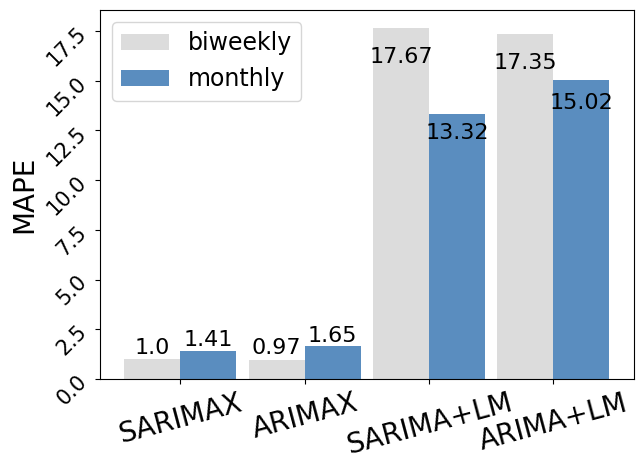

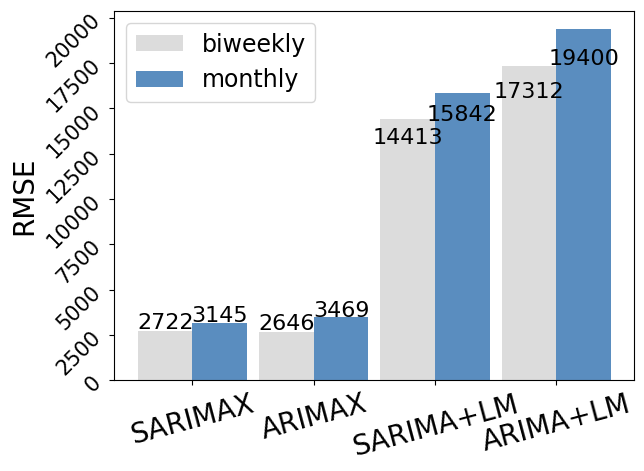

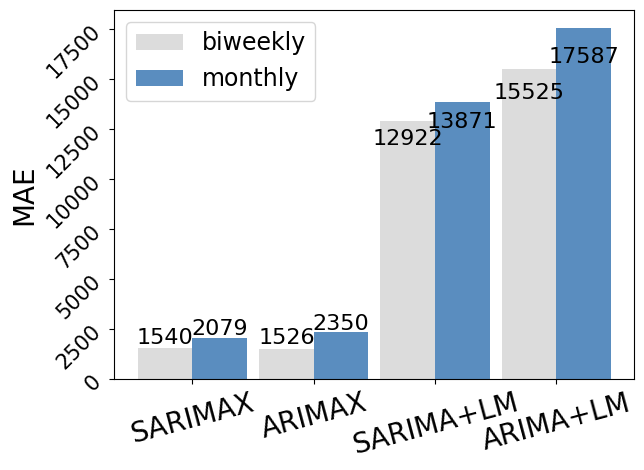

In [6]:
values_list = ['SARIMAX', 'ARIMAX', 'SARIMA+LM', 'ARIMA+LM']  # TS models to be compared towards the seasonality factor
metrics_list = ['MAPE' ,'RMSE', 'MAE']
models_list = ['sarimax_results', 'arimax_results', 'sarima_lm_results', 'arima_lm_results']

# Data sources
biweekly_results_df = pd.read_csv(os.path.join(DATA_PATH, 'final_results', 'biweekly_data_results.csv')).set_index('Approach')
biweekly_results_df = biweekly_results_df.rename(index={'sarimax_results': 'SARIMAX', 'arimax_results': 'ARIMAX', 'sarima_lm_results': 'SARIMA+LM', 'arima_lm_results': 'ARIMA+LM'})

monthly_results_df = pd.read_csv(os.path.join(DATA_PATH, 'final_results', 'monthly_data_results.csv')).set_index('Approach')
monthly_results_df = monthly_results_df.rename(index={'sarimax_results': 'SARIMAX', 'arimax_results': 'ARIMAX', 'sarima_lm_results': 'SARIMA+LM', 'arima_lm_results': 'ARIMA+LM'})


# Function to auto-label the bars, if desired
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        five_percent = height*0.125
        #print(f"height: {height}")
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height-five_percent),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=16)
# plt.rcParams["figure.figsize"] = (6.4, 6)
for i in range(len(metrics_list)):

    biweekly_results = biweekly_results_df.loc[values_list, metrics_list[i]]
    monthly_results = monthly_results_df.loc[values_list, metrics_list[i]]
    plot_data = pd.DataFrame({'biweekly': biweekly_results, 'monthly': monthly_results})
    # Plotting
    fig, ax = plt.subplots()
    x = np.arange(len(values_list))  # the label locations
    width = 0.45  # the width of the bars

    # Creating bars
    if i == 0:
        rects1 = ax.bar(x - width/2, plot_data['biweekly'], width, label='biweekly', color='#DCDCDC')
        rects2 = ax.bar(x + width/2, plot_data['monthly'], width, label='monthly', color='#5A8DBF')    
    else:
        rects1 = ax.bar(x - width/2, plot_data['biweekly'].round().astype(int), width, label='biweekly', color='#DCDCDC')
        rects2 = ax.bar(x + width/2, plot_data['monthly'].round().astype(int), width, label='monthly', color='#5A8DBF')

    # Adding some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel(metrics_list[i], fontsize=20)
    ax.set_title('')
    ax.set_xticks(x)
    ax.set_xticklabels(values_list, fontsize=20, rotation=15)
    ax.legend(fontsize=17)

    # Call the function to label bars
    autolabel(rects1)
    autolabel(rects2)
    plt.tight_layout()
    plt.yticks(fontsize=15, rotation=45)
    plt.savefig(os.path.join(DATA_PATH, f'{metrics_list[i]}.pdf'), format='pdf')
    plt.show()


# Visualization of 9 models on the resulting 14 projects

- For biweekly and monthly computation, just change the names of biweekly for monthly, and viceversa.

In [3]:
# Make a global dataframe with the results per project
DATA_PATH = "/Users/mrobredo23/OULU/JSS-TDpred2024/data"
metrics = ["MAPE", "MAE", "RMSE"]
ml_models = ["mlr","svr","xgb","rf","sgd","L1","L2"]
projects = ["archiva", "bcel", "codec", "collections", "commons-cli", "commons-exec", "configuration", "dbcp", "hive", "httpclient",
            "httpcore", "jxpath", "santuario", "validator"]
results_paths = ["arima_lm_results_clean", "arimax_results_clean", "sarima_lm_results_clean", "sarimax_results_clean",
                 "results_ML"]

# Empty dataframe
df_mape = pd.DataFrame(index=projects, columns=["projects"]+ml_models)
df_mae = pd.DataFrame(index=projects, columns=["projects"]+ml_models)
df_rmse = pd.DataFrame(index=projects, columns=["projects"]+ml_models)

# Time frame key
timeframe = "biweekly"

for result_path in results_paths:
    
    if result_path == "results_ML":
        
        for ml_result in ml_models:
            model_path = os.path.join(DATA_PATH, result_path, ml_result)
            # biweekly
            res = pd.read_csv(os.path.join(model_path, timeframe, "assessment.csv"))
            res['PROJECT'] = res['PROJECT'].str.strip().str.lower()
            res_filtered = res[res["PROJECT"].isin(projects)].copy()
            res_filtered.set_index("PROJECT", inplace=True)

            for project in projects:
                if project in res_filtered.index:
                    df_mape.loc[project, ml_result] = res_filtered.loc[project, 'MAPE']
                    df_mae.loc[project, ml_result] = res_filtered.loc[project, 'MAE']
                    df_rmse.loc[project, ml_result] = res_filtered.loc[project, 'RMSE']
        
    else:  # TSA models
        df_mape[result_path] = np.nan
        df_mae[result_path] = np.nan
        df_rmse[result_path] = np.nan

        model_path = os.path.join(DATA_PATH, result_path, f"{timeframe}_results")
        res = pd.read_csv(os.path.join(model_path, "assessment.csv"))
        res['PROJECT'] = res['PROJECT'].str.strip().str.lower()
        res_filtered = res[res["PROJECT"].isin(projects)].copy()
        res_filtered.set_index("PROJECT", inplace=True)
        for project in projects:
            if project in res_filtered.index:
                df_mape.loc[project, result_path] = res_filtered.loc[project, 'MAPE'].round(decimals=2)
                df_mae.loc[project, result_path] = res_filtered.loc[project, 'MAE'].round(decimals=2)
                df_rmse.loc[project, result_path] = res_filtered.loc[project, 'RMSE'].round(decimals=2)
    
    df_mape['projects'] = df_mape.index
    df_mae['projects'] = df_mae.index
    df_rmse['projects'] = df_rmse.index

    # Storing the results
    global_plot_path = os.path.join(DATA_PATH, "global_figure_results")
    if not os.path.exists(global_plot_path):
        os.mkdir(global_plot_path)

    df_mape = df_mape.rename(columns={"arima_lm_results_clean": "ARIMA+LM", "arimax_results_clean": "ARIMAX", "sarima_lm_results_clean": "SARIMA+LM", "sarimax_results_clean": "SARIMAX"})
    df_mae = df_mae.rename(columns={"arima_lm_results_clean": "ARIMA+LM", "arimax_results_clean": "ARIMAX", "sarima_lm_results_clean": "SARIMA+LM", "sarimax_results_clean": "SARIMAX"})
    df_rmse = df_rmse.rename(columns={"arima_lm_results_clean": "ARIMA+LM", "arimax_results_clean": "ARIMAX", "sarima_lm_results_clean": "SARIMA+LM", "sarimax_results_clean": "SARIMAX"})
        
    df_mape.to_csv(os.path.join(global_plot_path, f"mape_{timeframe}.csv"), index=False, encoding = "utf-8")
    df_mae.to_csv(os.path.join(global_plot_path, f"mae_{timeframe}.csv"), index=False, encoding = "utf-8")
    df_rmse.to_csv(os.path.join(global_plot_path, f"rmse_{timeframe}.csv"), index=False, encoding = "utf-8")

### Plotting the global results
- First cell: Normalization is done considering all values from the results dataframe
- Second cell: Normalization is done per project in each dataframe (So, each line of the df is scaled)

In [ ]:
import matplotlib.pyplot as plt

model_names = ["MLR","SVR","XGB","RF","SGD","L1","L2", "ARIMA+LM", "ARIMAX", "SARIMA+LM", "SARIMAX"]
# models = ["mlr","svr","xgb","rf","sgd","L1","L2", "ARIMA+LM", "ARIMAX", "SARIMA+LM", "SARIMAX"]
# Define the number of projects and models
num_projects = len(projects)
num_models = len(model_names)

for file in os.listdir(os.path.join(DATA_PATH, "global_figure_results")):
    clean_name = file.rstrip(".csv")
    metric = clean_name.split("_")[0]
    periodicity = clean_name.split("_")[1]

    # Get outcome files
    df = pd.read_csv(os.path.join(DATA_PATH, "global_figure_results", file), index_col=["projects"])
    
    # Set up a grid of subplots
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 20), constrained_layout=True)
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
    
    # Scaling the dataframe
    df_norm = (df-df.min())/(df.max()-df.min())
 
    # Plot each project's results in a separate subplot
    for i, (project, ax) in enumerate(zip(projects, axes)):
        
        scores = df_norm.loc[project]
        winner_index = scores.idxmin().upper()
        bars = ax.bar(model_names, scores, color='blue')
        ax.bar(model_names, df_norm.loc[project])
        ax.set_title(project)
        ax.set_ylim(0, 1)  # Assuming the data is normalized between 0 and 1
        ax.set_xticklabels(model_names, rotation=45, ha='right')

        bars[model_names.index(winner_index)].set_color('blue')

        for tick_label in ax.get_xticklabels():
            
            if tick_label.get_text() == winner_index:
                tick_label.set_fontweight('bold')
                tick_label.set_color('green')
            elif tick_label.get_text() == winner_index:
                tick_label.set_fontweight('bold')
                tick_label.set_color('green')
        
    # Hide any unused subplots (if there are any)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Show the plot
    plt.savefig(os.path.join(DATA_PATH, "global_figure_results", f"{clean_name}.pdf"))
    plt.show()

/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using

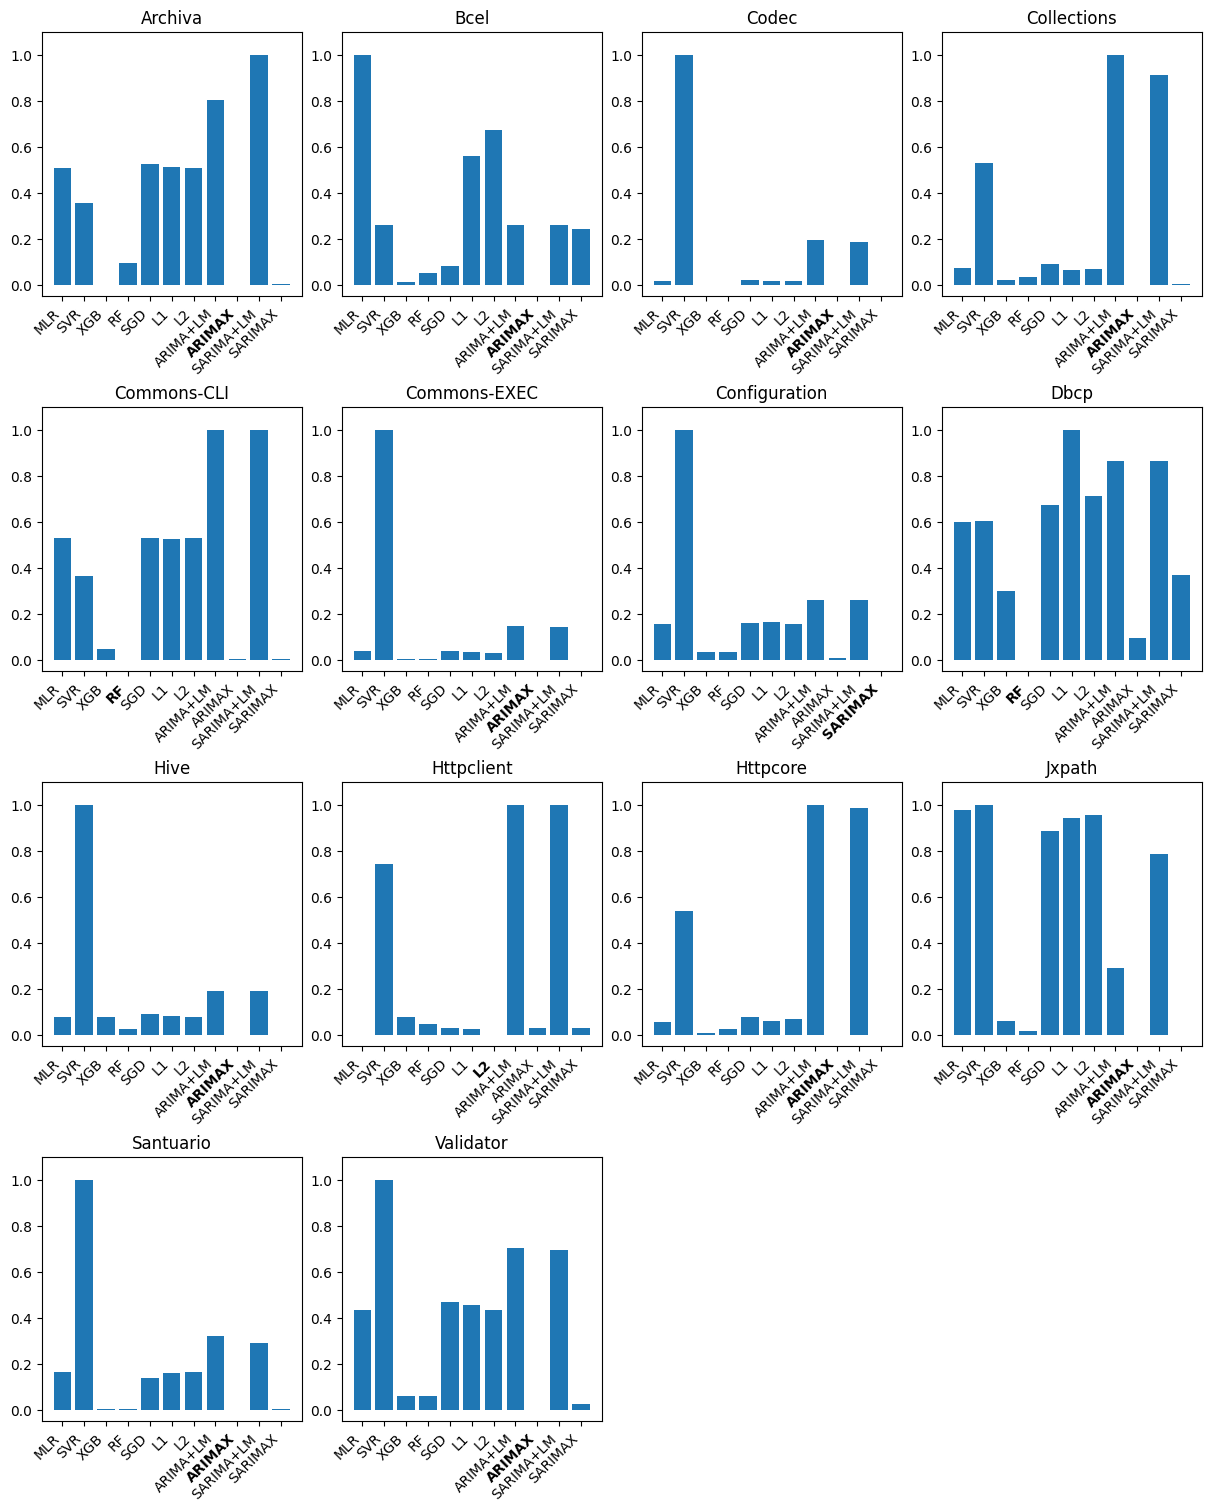

/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using

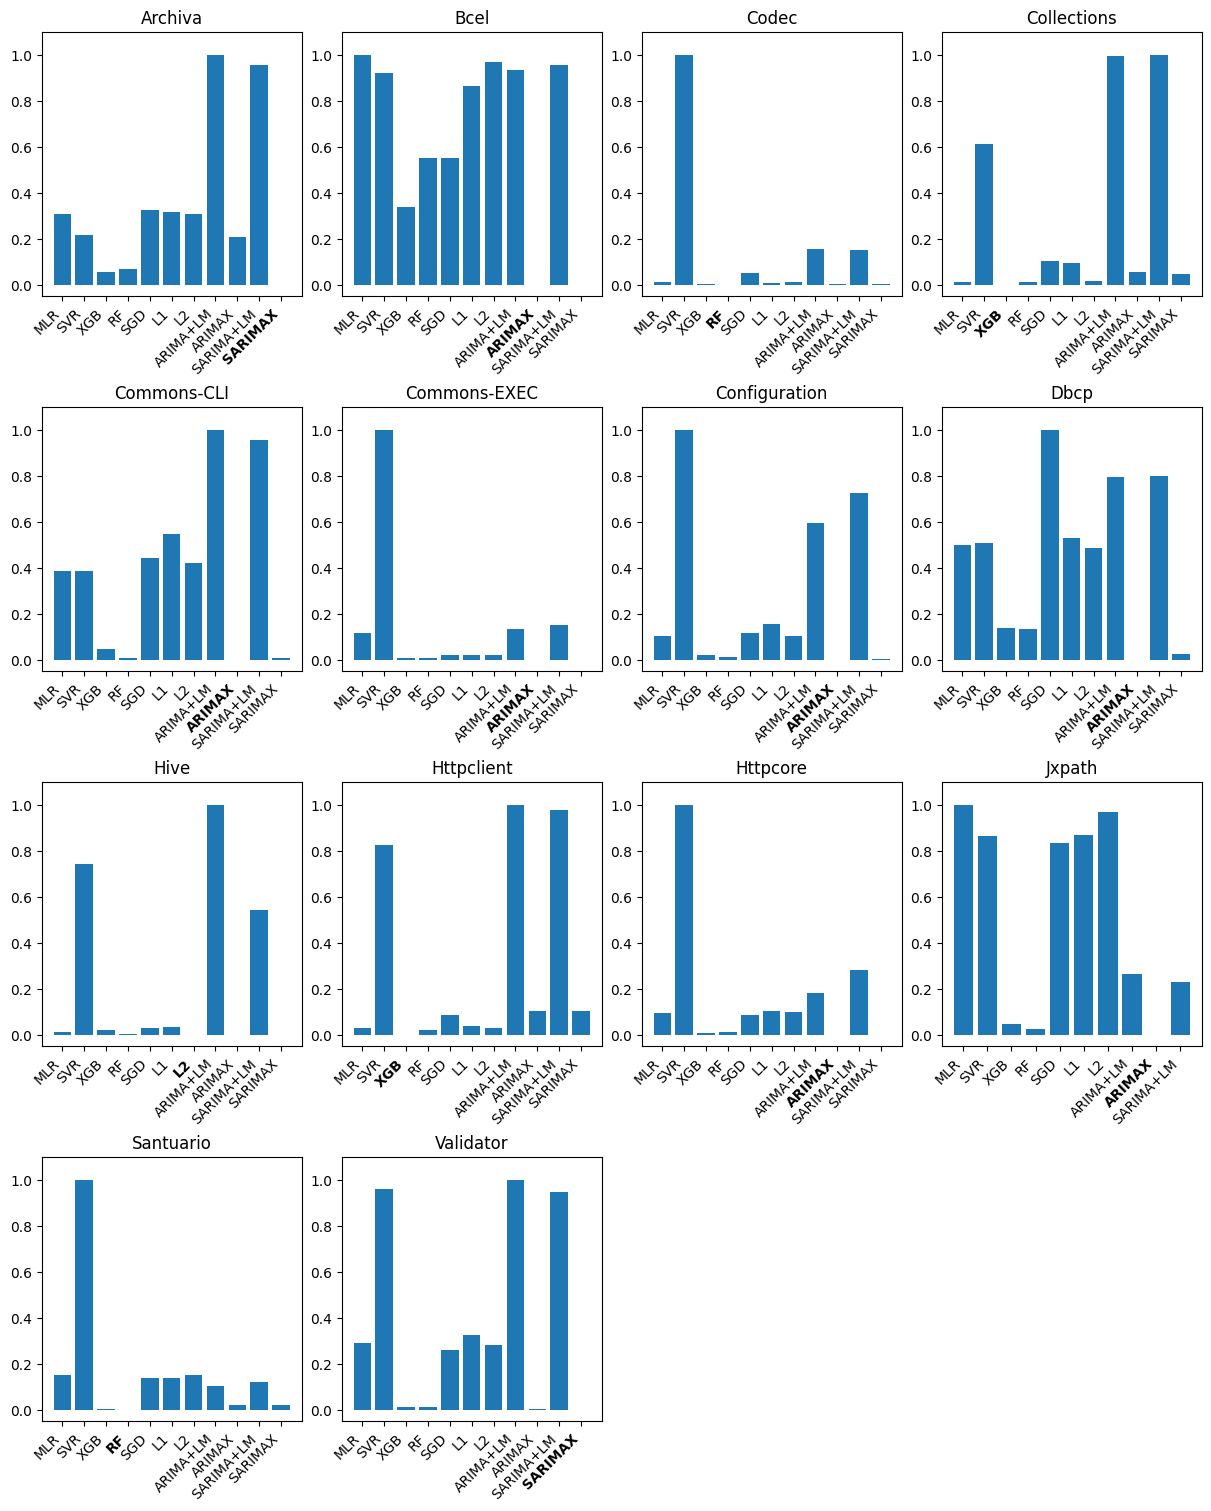

/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using

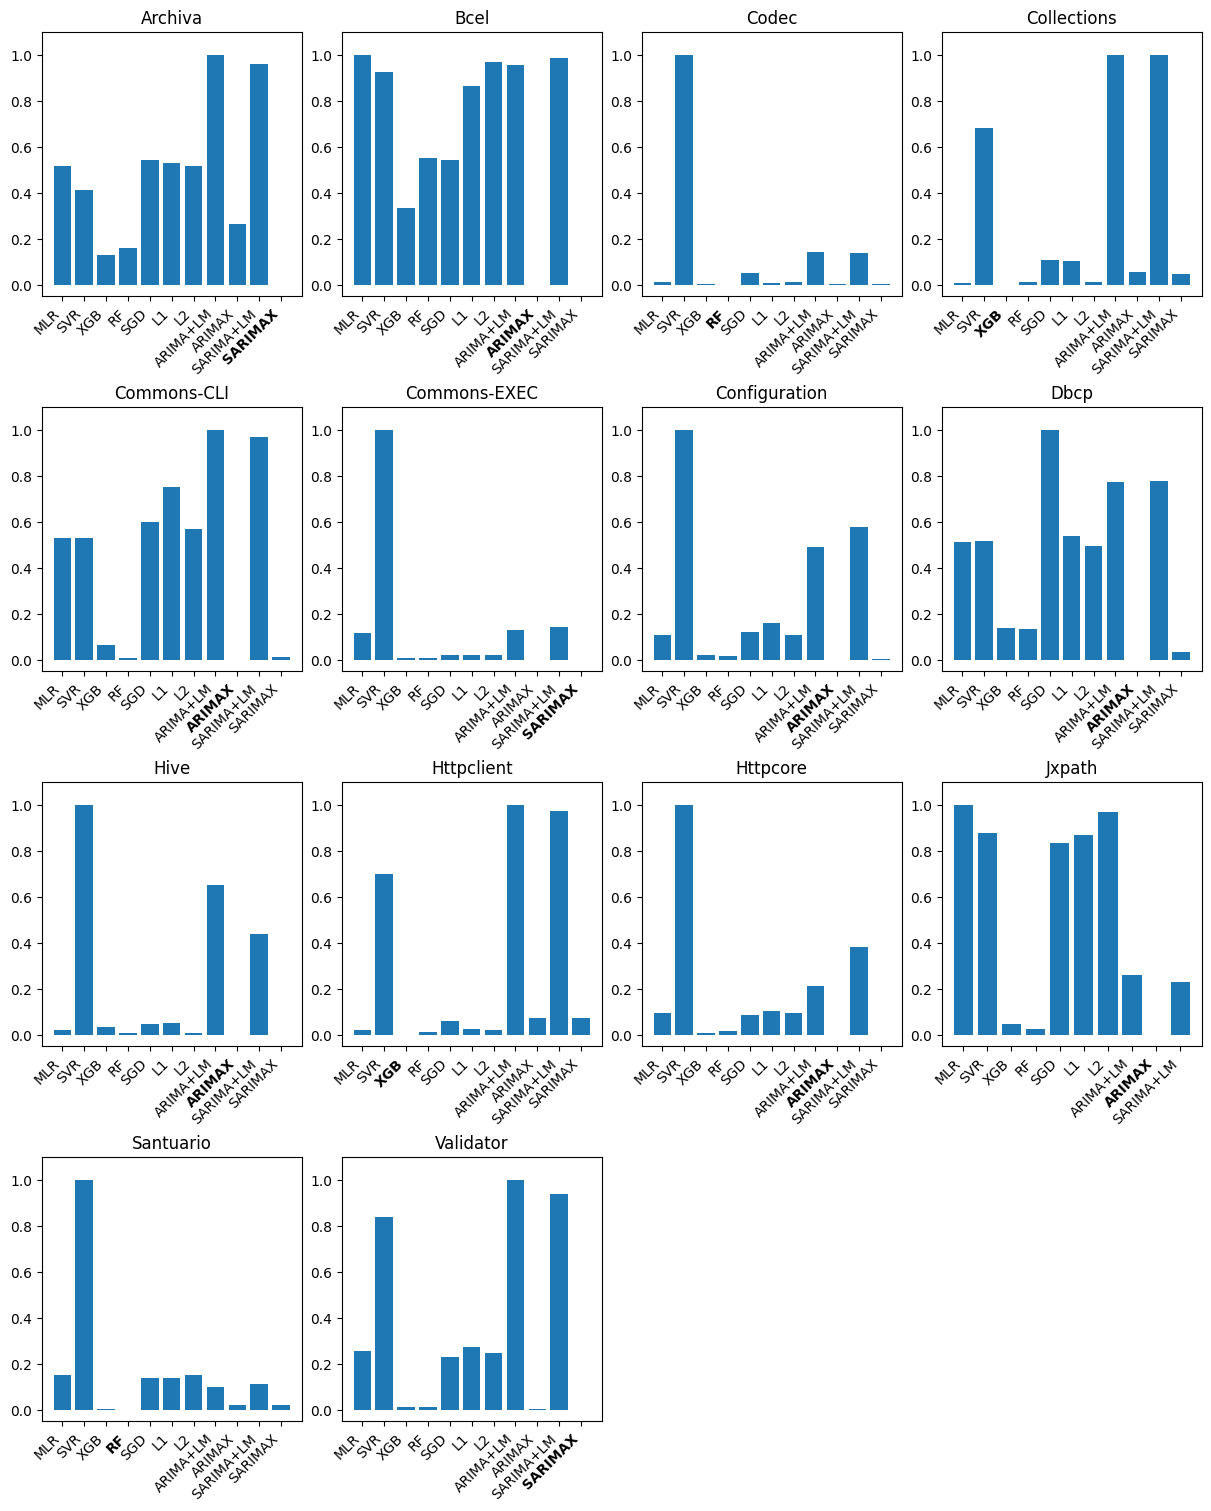

/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using

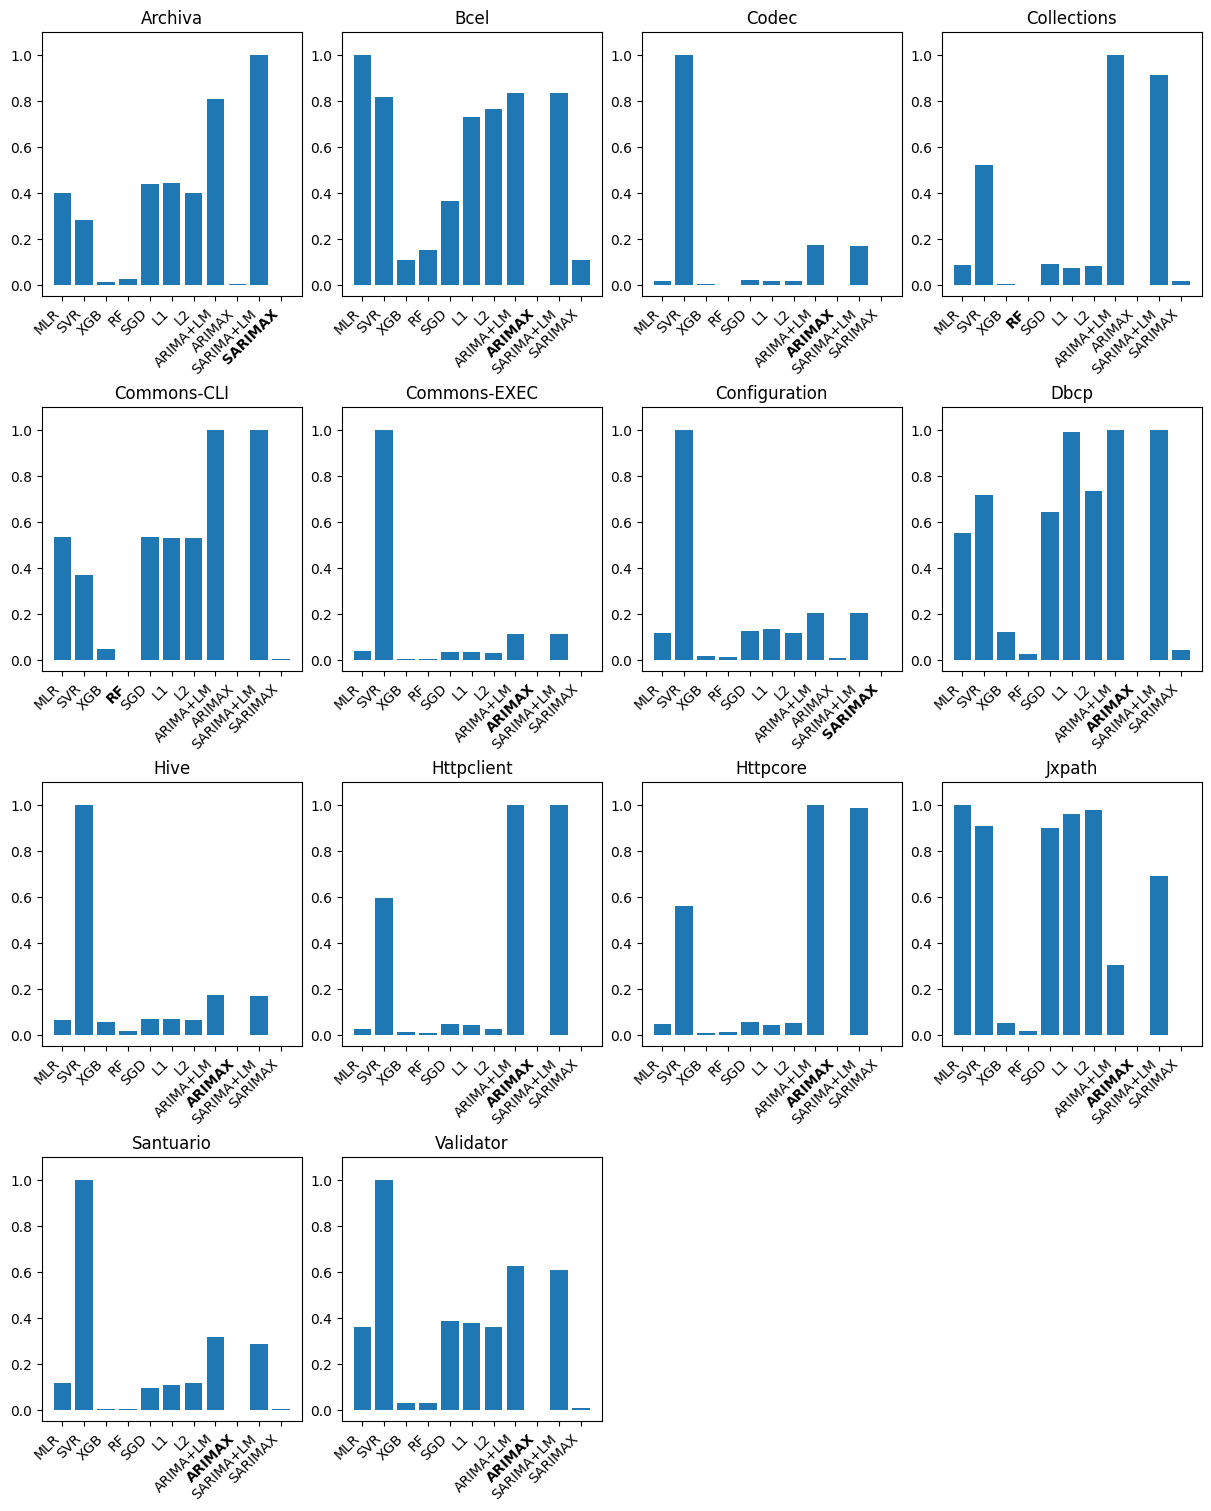

/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using

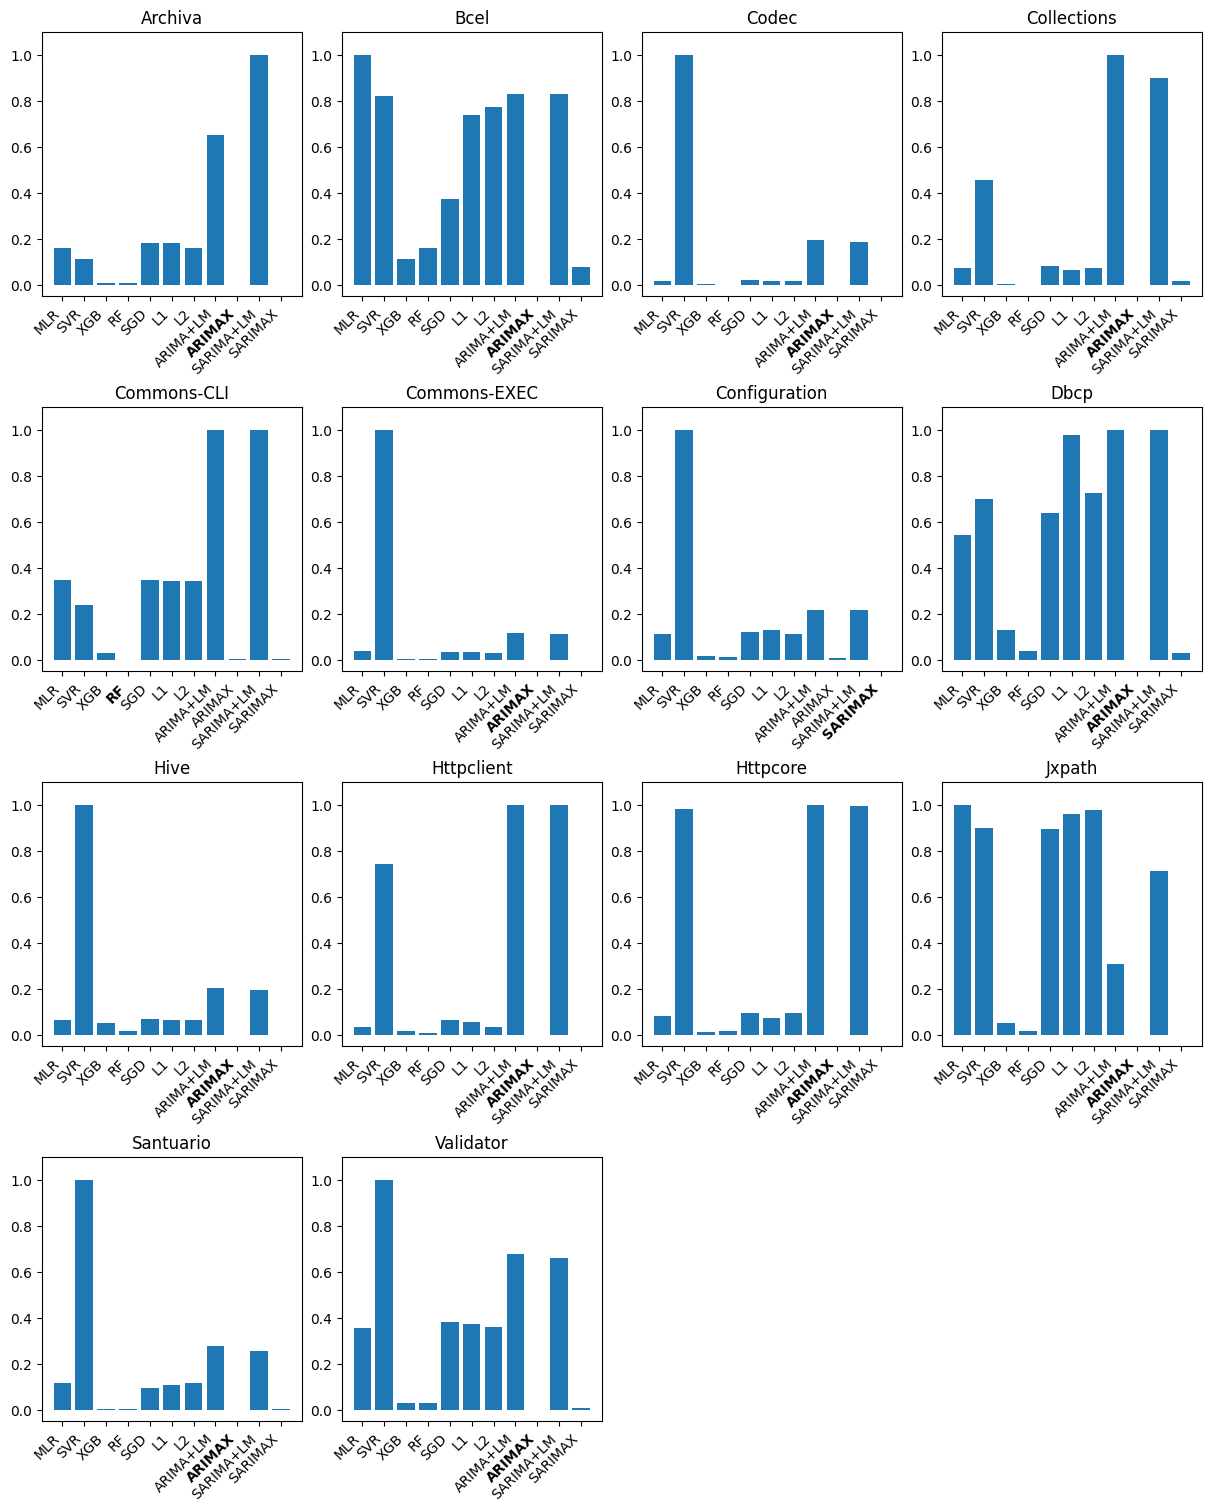

/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')
/var/folders/kb/sw0dnpps1cx45xw8zvrdypc80000gq/T/ipykernel_10660/212554103.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using

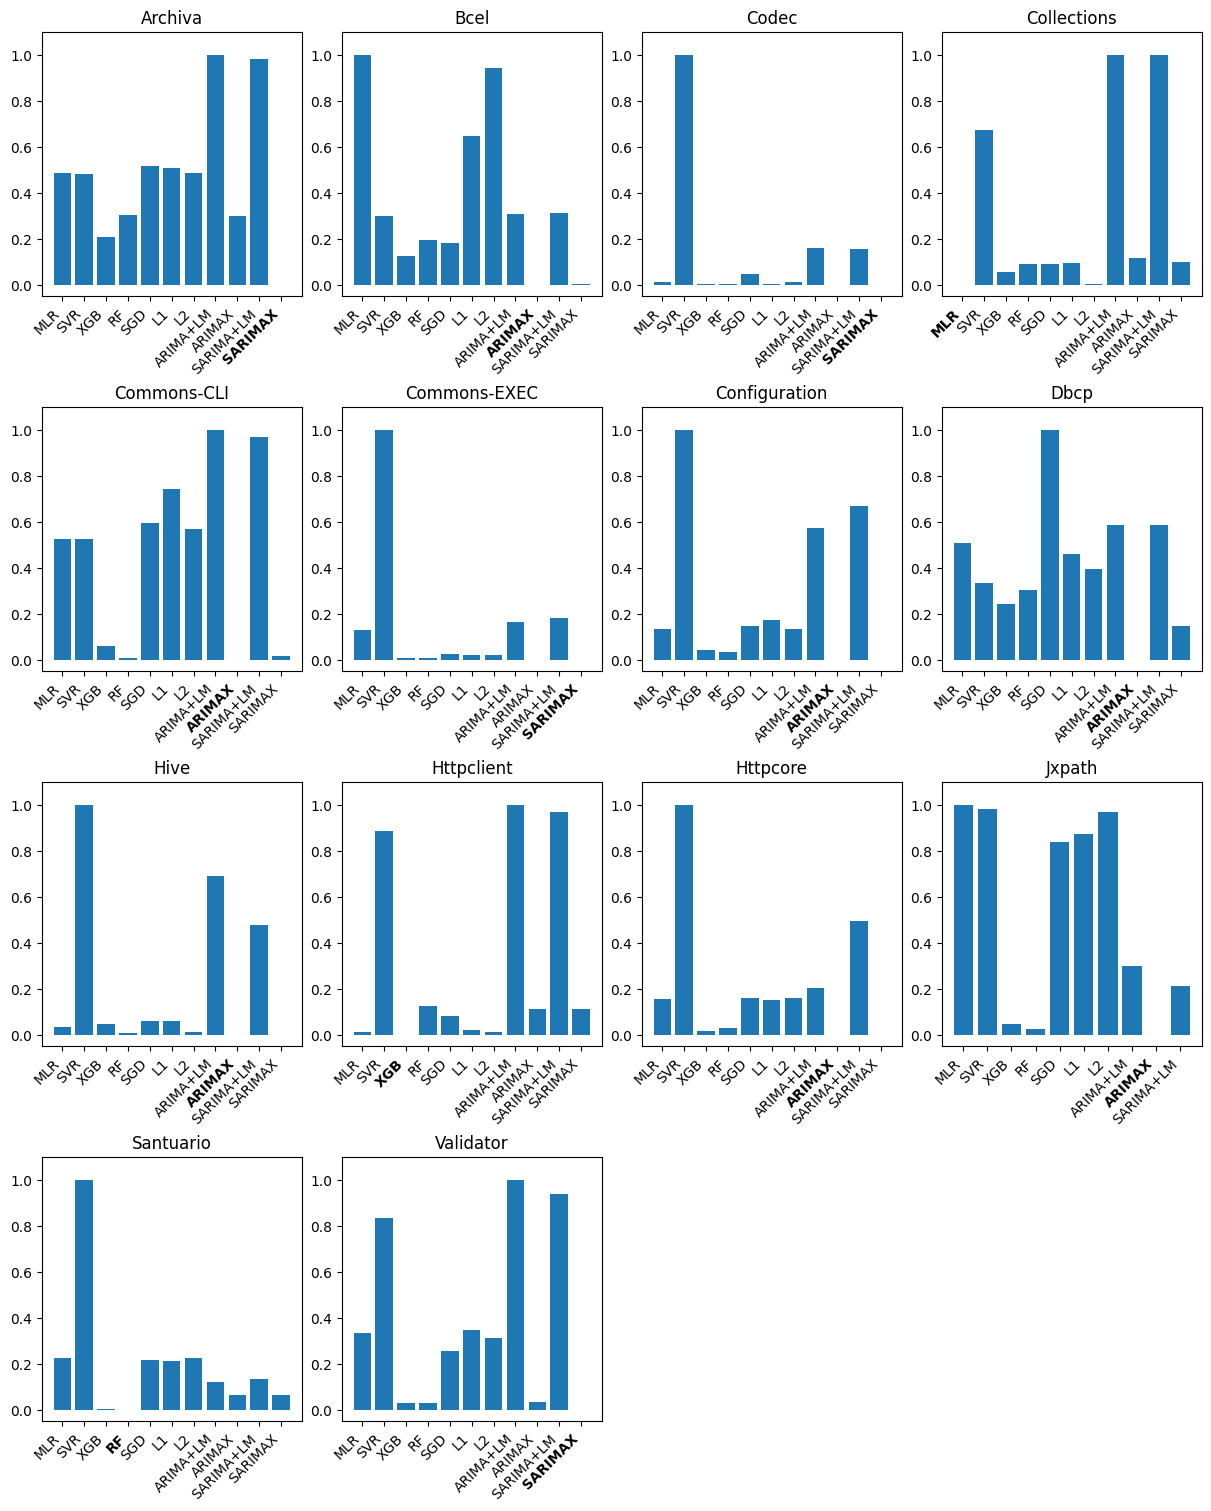

In [4]:
import matplotlib.pyplot as plt

model_names = ["MLR","SVR","XGB","RF","SGD","L1","L2", "ARIMA+LM", "ARIMAX", "SARIMA+LM", "SARIMAX"]
# models = ["mlr","svr","xgb","rf","sgd","L1","L2", "ARIMA+LM", "ARIMAX", "SARIMA+LM", "SARIMAX"]
# Define the number of projects and models
num_projects = len(projects)
num_models = len(model_names)

for file in os.listdir(os.path.join(DATA_PATH, "global_figure_results")):
    clean_name = file.rstrip(".csv")
    metric = clean_name.split("_")[0]
    periodicity = clean_name.split("_")[1]

    # Get outcome files
    df = pd.read_csv(os.path.join(DATA_PATH, "global_figure_results", file), index_col=["projects"])

    # Set up a grid of subplots
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 15), constrained_layout=True)
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

    # Scaling the dataframe
    # df_norm = (df-df.min())/(df.max()-df.min())

    # Plot each project's results in a separate subplot
    for i, (project, ax) in enumerate(zip(projects, axes)):

        scores = df.loc[project]
        winner_index = scores.idxmin().upper()
        scaled_vals = (df.loc[project] - df.loc[project].min()) / (df.loc[project].max() - df.loc[project].min())
        bars = ax.bar(model_names, scaled_vals, color='blue')
        ax.bar(model_names, scaled_vals)
        # ax.bar(model_names, df.loc[project])
        if project == "commons-cli" or project == "commons-exec":
            split_str = project.split("-")
            ax.set_title(f"{split_str[0].capitalize()}-{split_str[1].upper()}")
        else:
            ax.set_title(project.capitalize())
        #ax.margins(y=0.1)
        ax.set_ylim(-0.05, 1.1)  # Assuming the data is normalized between 0 and 1
        ax.set_xticklabels(model_names, rotation=45, ha='right')

        # bars[model_names.index(winner_index)].set_color('blue')

        for tick_label in ax.get_xticklabels():

            if tick_label.get_text() == winner_index:
                tick_label.set_fontweight('bold')
                #tick_label.set_color('green')
            elif tick_label.get_text() == winner_index:
                tick_label.set_fontweight('bold')
                #tick_label.set_color('green')

    # Hide any unused subplots (if there are any)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Show the plot
    plt.savefig(os.path.join(DATA_PATH, "global_figure_results", f"{clean_name}.pdf"))
    plt.show()